In [188]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import unicodedata
import re
import inflect
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from time import time
from sklearn.metrics import accuracy_score, confusion_matrix


In [189]:
print("###########")
print("#rrrrrrrrrrr")

###########
#rrrrrrrrrrr


**Opération des prétraitements**  

* supprimer les caractères non Ascii
* mettre en minuscule, 
* enlever les ponctuations
* remplacer les nombres par des mots
* enlever les stopwords.



In [190]:

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word) 
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def clean_text(text):
    tokens = word_tokenize(text)
    tokens=normalize(tokens)
    text="".join([" "+i for i in tokens]).strip()
    return text


In [191]:

url="/home/karim/Documents/Aigle/S2/Sciences de donnees/projet/claimskg_result.csv"
df = pd.read_csv(url, usecols=["text", "headline", "truthRating"])
# 5 premières lignes du fichier
display(df.head())
df.describe()
print(df.values)


,text,headline,truthRating
0,Malia Obama cashed a $1.2 million tax refund c...,Did Malia Obama Cash a $1.2 Million Check?,-1
1,High diver is saved from jumping into a draine...,High Diver Saved By Cross,-1
2,'And the revenue generated by drilling off Vir...,Moran says drilling off Virginia's coast will ...,2
3,Health insurance companies pay CEOs $24 millio...,Health care advocacy group blasts insurers for...,2
4,Ted Cruz said that veterans should start selli...,Ted Cruz: Vets Should Sell Cookies for Funding...,1


[['Malia Obama cashed a $1.2 million tax refund check.'
  'Did Malia Obama Cash a $1.2 Million Check?' -1]
 ['High diver is saved from jumping into a drained pool when he casts a cross-like shadow on the wall.'
  'High Diver Saved By Cross' -1]
 ["'And the revenue generated by drilling off Virginia’s coast? $40 million over 10 years.'"
  "Moran says drilling off Virginia's coast will net only $40 million for U.S. over 10 years"
  2]
 ...
 ["'Trump Management was charged with discriminating against African-Americans and breaking federal law.'"
  'Clinton ad: Trump Management was charged with discriminating against black people'
  3]
 ['The NAACP is calling for the removal of an historical Civil War carving from Stone Mountain, Georgia.'
  'Does the NAACP Want to Sandblast Confederate Figures Off Stone Mountain?'
  2]
 ["'Ted Cruz tried to ban contraception' five times."
  "Hillary Clinton's exaggerated claim that Ted Cruz 'tried to ban contraception' five times"
  2]]


***Chercher et enlever les valeurs manquantes***

Suppression des lignes pour lesquelles au moins un élément est manquant 

nombre de ligne supprimer =  118


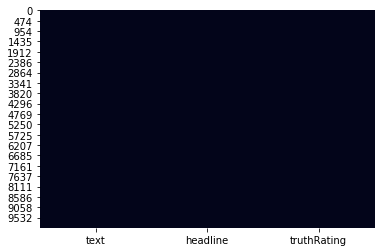

In [192]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)
count_row_orig = df.shape[0]
print ('Suppression des lignes pour lesquelles au moins un élément est manquant \n')
df.dropna(inplace=True)

print("nombre de ligne supprimer = ", count_row_orig - df.shape[0])

sns.heatmap(df.isnull(), cbar=False)

***Variables d'appprentissage et de prédiction***

On définit les variables d'apprentissage et la variable à prédire. Dans notre cas, truthRating est la variable à prédire. 

In [226]:
from sklearn.feature_extraction.text import CountVectorizer

print(df.shape)
array = df.values

X = array[:,  [0,1]]
#X=X.astype('string')
#df.columns = [x.decode("utf-8") for x in df.columns]

y = array[:, 2]
y=y.astype('int')

print(X)
print(y)

(9882, 3)
['Malia Obama cashed a $1.2 million tax refund check.'
 'High diver is saved from jumping into a drained pool when he casts a cross-like shadow on the wall.'
 "'And the revenue generated by drilling off Virginia’s coast? $40 million over 10 years.'"
 ...
 "'Trump Management was charged with discriminating against African-Americans and breaking federal law.'"
 'The NAACP is calling for the removal of an historical Civil War carving from Stone Mountain, Georgia.'
 "'Ted Cruz tried to ban contraception' five times."]
[['Malia Obama cashed a $1.2 million tax refund check.'
  'Did Malia Obama Cash a $1.2 Million Check?']
 ['High diver is saved from jumping into a drained pool when he casts a cross-like shadow on the wall.'
  'High Diver Saved By Cross']
 ["'And the revenue generated by drilling off Virginia’s coast? $40 million over 10 years.'"
  "Moran says drilling off Virginia's coast will net only $40 million for U.S. over 10 years"]
 ...
 ["'Trump Management was charged with 

***Notoyage des assertions***

In [194]:
def clean_assertions (data):
    for i in range(len(data)):
        #print (i)
        data[i]=clean_text(data[i])
    return data 

In [234]:
#np.savetxt('test12.txt', X, fmt='%s') 
print(type(X))
#X = np.array2string(X)
#print(type(X))
#X = clean_assertions(list(X))  
print(X.shape[0])



#print (len(corpus))
for i in range(X.shape[0]):
    X[i] = clean_assertions(X[i])
    
print(type(y))
print(y.shape)
print(type(X))
print(X.shape)
print(X)

<class 'numpy.ndarray'>
9882
<class 'numpy.ndarray'>
(9882,)
<class 'numpy.ndarray'>
(9882, 2)
[['malia obama cashed 12 million tax refund check'
  'malia obama cash 12 million check']
 ['high diver saved jumping drained pool casts crosslike shadow wall'
  'high diver saved cross']
 ['revenue generated drilling virginia coast forty million ten years'
  'moran says drilling virginia coast net forty million us ten years']
 ...
 ['trump management charged discriminating africanamericans breaking federal law'
  'clinton ad trump management charged discriminating black people']
 ['naacp calling removal historical civil war carving stone mountain georgia'
  'naacp want sandblast confederate figures stone mountain']
 ['ted cruz tried ban contraception five times'
  'hillary clinton exaggerated claim ted cruz tried ban contraception five times']]


In [251]:
#X = X.ravel()
#print(type(y))
#print(y.shape)
#print(type(X))
#print(X.shape)


#XX = X[:, 0] +' '+ X[:, 1];
#print(XX.shape)




#display(X[:,0])
#display(X[:,1])

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

df2 = pd.DataFrame(data=X, columns=["text", "headline"])

#print(df2.shape)

#display(df2)

transformer = FeatureUnion([
                ('text_tfidf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['text'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('headline_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x:  x["headline"], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())]))])

transformer.fit(df2)


search_vocab = transformer.transformer_list[0][1].steps[1][1].get_feature_names() 
product_vocab = transformer.transformer_list[1][1].steps[1][1].get_feature_names()
vocab = search_vocab + product_vocab

#print(vocab)
#print(transformer.transform(df2).toarray())


df3 = pd.DataFrame(
    data=transformer.transform(df2).toarray(),
    columns=vocab
)

display(df3)



#vectorizer = TfidfVectorizer()
#vectors = vectorizer.fit_transform()


#data['text'] = vectorizer.fit_transform(X[:,0])
#data['headline'] = vectorizer.fit_transform(X[:,1])

#X = data[['text', 'headline']].as_matrix()
#X = data_for_model[['tf_idf_q1', 'tf_idf_q2']].as_matrix()

#print(data['text'])

#X = vectors.toarray()
#print(X)
#print(y)

,005,02,025,04,045,047,05,06,07,08,...,zippo,zoe,zombie,zone,zones,zoo,zoos,zuckerberg,zuckerman,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
from sklearn.model_selection import train_test_split 
#30% du jeu de données pour le test
validation_size=0.3 
#70% du jeu de données pour l'apprentissage
testsize= 1-validation_size
seed=30
X_train,X_test,y_train,y_test=train_test_split(df3, 
                                               y, 
                                               train_size=validation_size, 
                                               random_state=seed,
                                               test_size=testsize)
#print(y_test)


In [254]:
clf = GaussianNB()
clf.fit(X_train, y_train)

result = clf.predict(X_test)

print(result)

print('\n accuracy :', 
      accuracy_score(result, y_test),'\n')


[ 1  1  1 ... -1  2  1]

 accuracy : 0.43972246313963576 



***Mise en place de cross validation***
Pour que notre modèle soit appris sur plusieurs jeux de donnés, on a appliqué  10-fold cross validation pour évaluer la qulité du modèle. En effet, Le jeu de données sera découpé en 10 partie. Du coup, notre modèle sera entrainé sur 9 partie et testé sur une.

In [119]:
seed=7
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
clf = GaussianNB()

scoring = 'accuracy'
t0 = time()
score = cross_val_score(clf, X, y, cv=k_fold, scoring=scoring)
print("Réalisé en %0.3fs" % (time() - t0))

print('Les différentes accuracy pour les 10 évaluations sont : \n',
      score,'\n')
print ('Accuracy moyenne : ',score.mean(), 
       ' standard deviation', score.std())

Réalisé en 30.403s
Les différentes accuracy pour les 10 évaluations sont : 
 [0.369 0.368 0.371 0.383 0.351 0.394 0.358 0.368 0.375 0.38 ] 

Accuracy moyenne :  0.37170000000000003  standard deviation 0.011645170672858352
